# 线性拟合

或者说是多分类的支持向量机(SVM）

# 代码参考
[CS231n计算机视觉课程-多分类SVM](https://www.heywhale.com/mw/project/5e82bc8b246a590036b8e5d6)

In [1]:
# 导入数据
from torchvision import datasets
data_path='data-cifar10/'
cifar10=datasets.CIFAR10(data_path,train=True,download=True)
cifar10_val=datasets.CIFAR10(data_path,train=False,download=True)

import numpy as np

Files already downloaded and verified
Files already downloaded and verified


In [2]:
#数据集划分

X_train, y_train=cifar10.data,np.array(cifar10.targets)
# 作为一个完整性检查，我们打印出训练和测试数据的大小。
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

X_test, y_test=cifar10_val.data,np.array(cifar10_val.targets)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


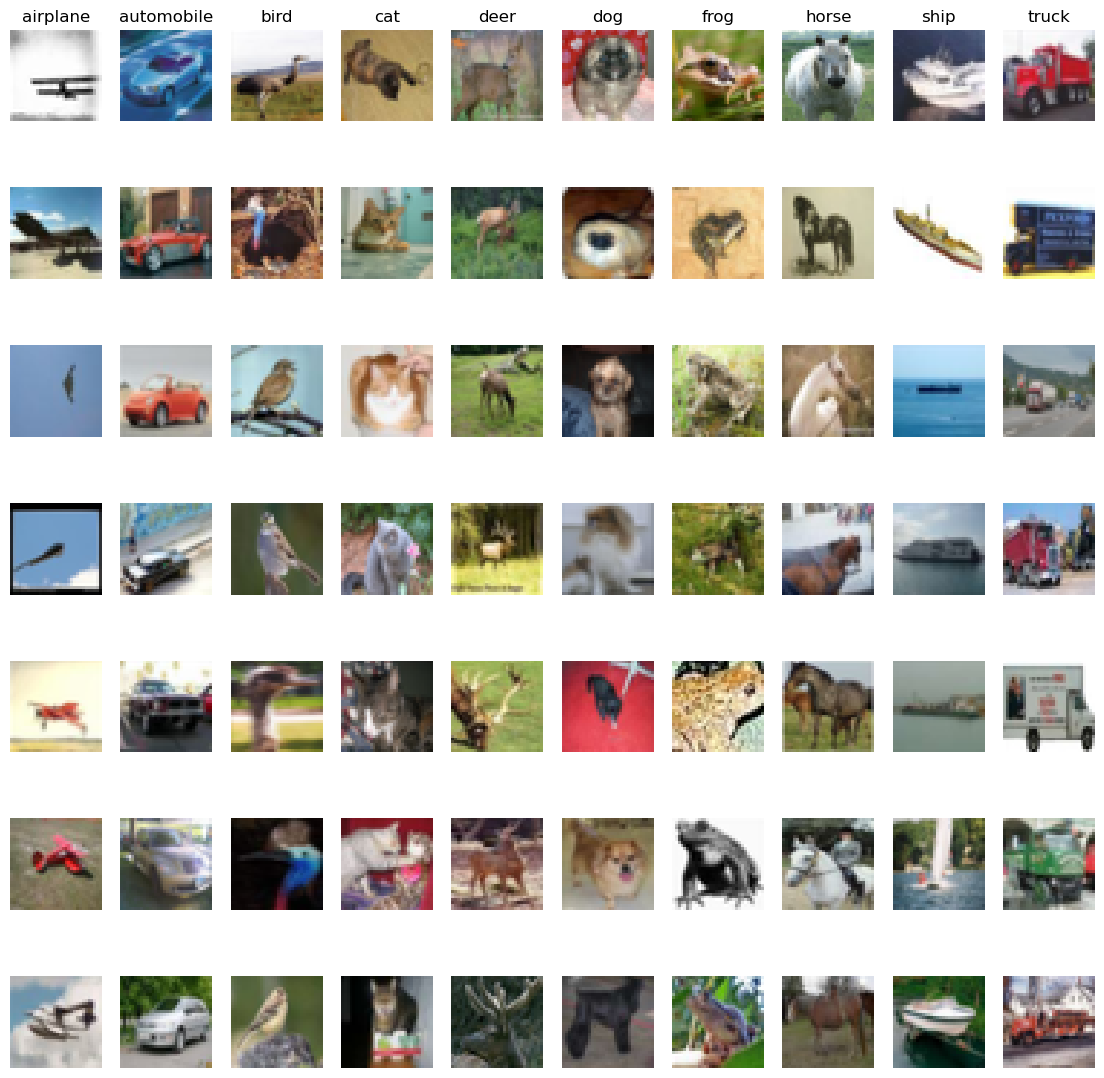

In [3]:
#预览数据
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest' # 设置图像的插值方式。该设置用于在显示图像时缩放图像的方式。此处设置为“最近邻插值”，即当图像缩放时每个像素点的颜色值是最近的像素点颜色。 
plt.rcParams['image.cmap'] = 'gray' # 设置绘图的默认颜色映射方案。这里设置为'gray'，绘图时将会显示为灰度图像。 

# 从数据集中可视化一些示例。
# 我们展示了一些例子的训练图像从每个类。
classes = cifar10.classes
num_classes = len(classes)
samples_per_class = 7
plt.figure(figsize=(14, 14))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) #numpy来取
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# X_train * np.sqrt(variance) + mean

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# 将图像数据拉成一条线
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(50000, 3072) (10000, 3072)


In [6]:
#做一下下数据标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
mean = scaler.mean_
variance = scaler.var_
print(mean)
print(variance)

[130.71074 136.05614 132.5538  ... 126.63908 125.8503  114.38186]
[5389.34218866 5315.4673083  6472.03302556 ... 4215.33793675 3924.85456991
 4366.15216294]


In [8]:
mean.shape

(3072,)

In [9]:
np.ones((X_train.shape[0],1))#(3072,1)大小的全1矩阵，或者理解为列向量也行
X_train=np.hstack([X_train,np.ones((X_train.shape[0],1))])#很直观的，在最后一个位置，加一列数据的方法
X_test=np.hstack([X_test,np.ones((X_test.shape[0],1))])#很直观的，在最后一个位置，加一列数据的方法

print(X_train.shape, X_test.shape)

(50000, 3073) (10000, 3073)


In [10]:
#这么来整，将训练集划分为训练的，和评估的数据
import torch
X_train_torch = torch.from_numpy(X_train)
X_test_torch = torch.from_numpy(X_test)
y_train_torch = torch.from_numpy(y_train)
y_test_torch = torch.from_numpy(y_test)

total_size = len(X_train_torch)
val_size = total_size // 10
train_size = total_size - val_size

dataset = list(zip(X_train_torch, y_train_torch))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataset.dataset[0]

(tensor([-0.9768, -1.0158, -0.8646,  ..., -0.5403, -0.6414,  1.0000],
        dtype=torch.float64),
 tensor(6, dtype=torch.int32))

In [11]:
%%time
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,
          batch_size=16,
          shuffle=True,
          num_workers=4,
          pin_memory=True)

for _,(i,j) in enumerate(train_loader):
    print(i.shape)
    print(j.shape)
    break
    
# torch.Size([16, 3073])
# torch.Size([16])


torch.Size([16, 3073])
torch.Size([16])
CPU times: total: 8.08 s
Wall time: 13.4 s


In [12]:
%%time
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset,
          batch_size=16,
          shuffle=True,
          num_workers=8,
          pin_memory=True)

for _,(i,j) in enumerate(train_loader):
    print(i.shape)
    print(j.shape)
    break

#时间反而更久了，看来这个多线程数，得合适

torch.Size([16, 3073])
torch.Size([16])
CPU times: total: 11 s
Wall time: 24.4 s


In [13]:
%%time
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset,
          batch_size=16,
          shuffle=True,
          num_workers=1,
          pin_memory=True)

for _,(i,j) in enumerate(train_loader):
    print(i.shape)
    print(j.shape)
    break

#行吧，我估计是因为再jupyter里面跑的，在外边应该会快的叭。以后试试

torch.Size([16, 3073])
torch.Size([16])
CPU times: total: 1.34 s
Wall time: 3.32 s


In [14]:
X_train.shape[1]

3073

In [20]:
# 加载数据
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset,
          batch_size=16,
          shuffle=True,
          num_workers=1,
          pin_memory=True)

# 写下SVM模型
import torch
import torch.nn as nn
#懂了，我这里写错了多分类问题
class SVM(nn.Module):
    def __init__(self, n_features,n_labels):
        super(SVM, self).__init__()
        self.fc = nn.Linear(n_features, n_labels, bias=False)#多了一列1作为偏置，就可以写一个无偏置层，一个技巧，虽然我不知道有没有效果

    def forward(self, x):
        return self.fc(x)
    
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

# loss = criterion(predictions, labels)

# # 最后，输出这个损失值，你看看这个可爱的结果是不是很棒呢~
# print("交叉熵损失值: ", loss.item())
# #计算损失

model = SVM(X_train.shape[1],len(cifar10.classes))#特征的数量，类似全连接叭
from torch.optim import Adam
optimizer = Adam(model.parameters())
epochs=100

In [21]:
val_loader = DataLoader(val_dataset,
          batch_size=512,
          shuffle=True,
          num_workers=1,
          pin_memory=True)

In [22]:
cuda = True if torch.cuda.is_available() else False
dev = torch.device("cpu") if not cuda else torch.device("cuda")
model = model.to(dev)

In [23]:
%%time
def accuracy(predicted, labels):
    _, preds = torch.max(predicted, dim=1)  # 按行取最大值，返回最大值以及对应的索引
    correct = torch.sum(preds == labels.squeeze())  # 统计预测正确的数量，squeeze()将标签张量的维度压缩，使其与预测张量维度一致
    #acc = correct.float() / float(labels.size(0))  # 计算准确率
    return correct.float()

from tqdm import tqdm
import torch.nn.functional as F

# output = model(input)   # 模型输出，形状为（512，10）
#   # 进行softmax，dim=1表示在每行进行操作，输出形状为（512，10）

for epoch in range(1, epochs + 1):
    epoch_loss=0
    model.train()
    for _,(img_fea,labels) in tqdm(enumerate(train_loader), desc='Train data'):
        optimizer.zero_grad()
        img_fea = img_fea.to(dev).float()
        labels = labels.to(dev)
        labels_pre = model(img_fea)
        labels_pre = F.softmax(labels_pre, dim=1)
        loss = loss_fn(labels_pre, labels.long())#交叉熵损失
        epoch_loss+=loss.item()
        loss.backward()
        optimizer.step()
    print("Epoch %d: loss %f" %(epoch,loss))
    #计算准确率
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for val_img_fea, val_label in val_loader:
            val_img_fea = val_img_fea.to(dev).float()
            val_label = val_label.to(dev)
            val_label_pre = model(val_img_fea)
            # Assuming binary classification with 1 and -1 as class labels
            # 调用函数计算准确率          
#             acc = 
#             predicted = torch.sign(val_label_pre).T[0] # Convert predictions to either 1 or -1
            total += val_label.size(0)
            correct += accuracy(val_label_pre, val_label)#这里就不用放缩了，我取的是最大值
    
    acc = 100 * correct / total
    print(f'Validation Accuracy: {acc:.2f}%')

#太懒了，就这样吧

Train data: 2813it [00:03, 886.20it/s] 


Epoch 1: loss 1.834913
Validation Accuracy: 34.02%


Train data: 2813it [00:03, 913.21it/s] 


Epoch 2: loss 1.717485
Validation Accuracy: 34.34%


Train data: 2813it [00:02, 967.67it/s] 


Epoch 3: loss 2.078560
Validation Accuracy: 37.02%


Train data: 2813it [00:03, 895.42it/s] 


Epoch 4: loss 2.089917
Validation Accuracy: 36.88%


Train data: 2813it [00:03, 883.87it/s] 


Epoch 5: loss 2.086266
Validation Accuracy: 36.72%


Train data: 2813it [00:03, 890.07it/s] 


Epoch 6: loss 2.202895
Validation Accuracy: 36.18%


Train data: 2813it [00:02, 1029.65it/s]


Epoch 7: loss 1.963826
Validation Accuracy: 37.28%


Train data: 2813it [00:02, 985.00it/s] 


Epoch 8: loss 2.210852
Validation Accuracy: 37.36%


Train data: 2813it [00:02, 947.16it/s] 


Epoch 9: loss 1.960878
Validation Accuracy: 37.40%


Train data: 2813it [00:03, 871.94it/s] 


Epoch 10: loss 2.086060
Validation Accuracy: 37.80%


Train data: 2813it [00:02, 976.11it/s] 


Epoch 11: loss 2.086150
Validation Accuracy: 38.62%


Train data: 2813it [00:02, 1005.12it/s]


Epoch 12: loss 2.211111
Validation Accuracy: 38.84%


Train data: 2813it [00:02, 1008.62it/s]


Epoch 13: loss 1.872562
Validation Accuracy: 38.44%


Train data: 2813it [00:02, 1023.29it/s]


Epoch 14: loss 2.085804
Validation Accuracy: 38.72%


Train data: 2813it [00:03, 896.54it/s] 


Epoch 15: loss 2.211065
Validation Accuracy: 38.52%


Train data: 2813it [00:02, 996.61it/s] 


Epoch 16: loss 2.070055
Validation Accuracy: 38.40%


Train data: 2813it [00:03, 886.34it/s] 


Epoch 17: loss 2.210519
Validation Accuracy: 38.42%


Train data: 2813it [00:03, 900.74it/s] 


Epoch 18: loss 1.961150
Validation Accuracy: 38.70%


Train data: 2813it [00:02, 1049.75it/s]


Epoch 19: loss 1.960930
Validation Accuracy: 38.62%


Train data: 2813it [00:03, 901.30it/s] 


Epoch 20: loss 2.211191
Validation Accuracy: 39.86%


Train data: 2813it [00:02, 1023.27it/s]


Epoch 21: loss 2.082110
Validation Accuracy: 38.66%


Train data: 2813it [00:03, 863.48it/s] 


Epoch 22: loss 1.959037
Validation Accuracy: 39.14%


Train data: 2813it [00:03, 898.78it/s] 


Epoch 23: loss 1.825077
Validation Accuracy: 38.92%


Train data: 2813it [00:03, 905.03it/s] 


Epoch 24: loss 2.086149
Validation Accuracy: 39.18%


Train data: 2813it [00:03, 913.02it/s] 


Epoch 25: loss 2.211192
Validation Accuracy: 39.06%


Train data: 2813it [00:03, 907.29it/s] 


Epoch 26: loss 2.306470
Validation Accuracy: 39.12%


Train data: 2813it [00:02, 1067.05it/s]


Epoch 27: loss 1.709680
Validation Accuracy: 39.52%


Train data: 2813it [00:03, 910.07it/s] 


Epoch 28: loss 2.086150
Validation Accuracy: 38.92%


Train data: 2813it [00:02, 1017.17it/s]


Epoch 29: loss 1.745125
Validation Accuracy: 38.86%


Train data: 2813it [00:03, 755.40it/s]


Epoch 30: loss 2.085377
Validation Accuracy: 39.34%


Train data: 2813it [00:02, 1032.10it/s]


Epoch 31: loss 2.076780
Validation Accuracy: 39.54%


Train data: 2813it [00:02, 939.88it/s] 


Epoch 32: loss 1.961150
Validation Accuracy: 39.46%


Train data: 2813it [00:02, 961.90it/s] 


Epoch 33: loss 1.837602
Validation Accuracy: 39.16%


Train data: 2813it [00:02, 1006.03it/s]


Epoch 34: loss 1.711151
Validation Accuracy: 39.04%


Train data: 2813it [00:03, 868.96it/s] 


Epoch 35: loss 2.082251
Validation Accuracy: 39.50%


Train data: 2813it [00:02, 937.72it/s] 


Epoch 36: loss 2.097567
Validation Accuracy: 39.56%


Train data: 2813it [00:03, 899.08it/s] 


Epoch 37: loss 2.210913
Validation Accuracy: 39.58%


Train data: 2813it [00:02, 1001.25it/s]


Epoch 38: loss 2.209063
Validation Accuracy: 39.14%


Train data: 2813it [00:02, 971.29it/s] 


Epoch 39: loss 2.208971
Validation Accuracy: 39.42%


Train data: 2813it [00:03, 871.03it/s] 


Epoch 40: loss 2.086150
Validation Accuracy: 39.34%


Train data: 2813it [00:03, 895.60it/s] 


Epoch 41: loss 2.336086
Validation Accuracy: 39.04%


Train data: 2813it [00:02, 984.16it/s] 


Epoch 42: loss 1.833196
Validation Accuracy: 39.24%


Train data: 2813it [00:03, 909.56it/s] 


Epoch 43: loss 1.956473
Validation Accuracy: 39.74%


Train data: 2813it [00:02, 1057.76it/s]


Epoch 44: loss 2.076734
Validation Accuracy: 39.22%


Train data: 2813it [00:03, 936.96it/s] 


Epoch 45: loss 1.992337
Validation Accuracy: 39.82%


Train data: 2813it [00:03, 894.34it/s] 


Epoch 46: loss 2.206763
Validation Accuracy: 40.54%


Train data: 2813it [00:03, 887.97it/s] 


Epoch 47: loss 1.713783
Validation Accuracy: 39.98%


Train data: 2813it [00:02, 976.34it/s] 


Epoch 48: loss 1.961158
Validation Accuracy: 40.00%


Train data: 2813it [00:02, 989.38it/s] 


Epoch 49: loss 1.844093
Validation Accuracy: 39.22%


Train data: 2813it [00:03, 897.39it/s] 


Epoch 50: loss 1.832030
Validation Accuracy: 39.22%


Train data: 2813it [00:02, 1006.98it/s]


Epoch 51: loss 1.958896
Validation Accuracy: 39.56%


Train data: 2813it [00:02, 969.65it/s] 


Epoch 52: loss 1.961150
Validation Accuracy: 39.24%


Train data: 2813it [00:03, 901.66it/s] 


Epoch 53: loss 1.830218
Validation Accuracy: 40.24%


Train data: 2813it [00:02, 997.14it/s] 


Epoch 54: loss 1.836168
Validation Accuracy: 39.98%


Train data: 2813it [00:02, 993.93it/s] 


Epoch 55: loss 2.054164
Validation Accuracy: 39.80%


Train data: 2813it [00:03, 936.48it/s] 


Epoch 56: loss 2.210062
Validation Accuracy: 40.14%


Train data: 2813it [00:02, 1025.76it/s]


Epoch 57: loss 2.212861
Validation Accuracy: 40.02%


Train data: 2813it [00:03, 920.54it/s] 


Epoch 58: loss 1.836150
Validation Accuracy: 39.62%


Train data: 2813it [00:02, 1003.24it/s]


Epoch 59: loss 1.955729
Validation Accuracy: 40.66%


Train data: 2813it [00:03, 896.93it/s] 


Epoch 60: loss 1.961302
Validation Accuracy: 40.12%


Train data: 2813it [00:03, 919.14it/s] 


Epoch 61: loss 1.734280
Validation Accuracy: 39.10%


Train data: 2813it [00:03, 912.46it/s] 


Epoch 62: loss 1.836148
Validation Accuracy: 39.62%


Train data: 2813it [00:03, 877.16it/s] 


Epoch 63: loss 2.086203
Validation Accuracy: 39.76%


Train data: 2813it [00:03, 907.58it/s] 


Epoch 64: loss 2.078568
Validation Accuracy: 39.98%


Train data: 2813it [00:03, 920.69it/s] 


Epoch 65: loss 1.836252
Validation Accuracy: 40.12%


Train data: 2813it [00:03, 882.13it/s] 


Epoch 66: loss 1.836150
Validation Accuracy: 39.38%


Train data: 2813it [00:03, 892.18it/s] 


Epoch 67: loss 2.211150
Validation Accuracy: 39.76%


Train data: 2813it [00:03, 905.92it/s] 


Epoch 68: loss 2.213480
Validation Accuracy: 41.06%


Train data: 2813it [00:03, 916.99it/s] 


Epoch 69: loss 1.959633
Validation Accuracy: 39.92%


Train data: 2813it [00:02, 1027.82it/s]


Epoch 70: loss 1.969946
Validation Accuracy: 40.44%


Train data: 2813it [00:03, 933.39it/s] 


Epoch 71: loss 2.215648
Validation Accuracy: 40.06%


Train data: 2813it [00:03, 897.56it/s] 


Epoch 72: loss 2.116597
Validation Accuracy: 39.64%


Train data: 2813it [00:03, 903.58it/s] 


Epoch 73: loss 1.708969
Validation Accuracy: 40.42%


Train data: 2813it [00:03, 888.37it/s] 


Epoch 74: loss 1.960780
Validation Accuracy: 39.56%


Train data: 2813it [00:03, 913.16it/s] 


Epoch 75: loss 1.961120
Validation Accuracy: 40.16%


Train data: 2813it [00:03, 904.85it/s] 


Epoch 76: loss 2.086129
Validation Accuracy: 39.48%


Train data: 2813it [00:02, 1018.52it/s]


Epoch 77: loss 2.210548
Validation Accuracy: 39.88%


Train data: 2813it [00:03, 928.29it/s] 


Epoch 78: loss 2.082627
Validation Accuracy: 40.44%


Train data: 2813it [00:02, 983.22it/s] 


Epoch 79: loss 1.961150
Validation Accuracy: 40.52%


Train data: 2813it [00:02, 1001.95it/s]


Epoch 80: loss 1.960630
Validation Accuracy: 40.88%


Train data: 2813it [00:03, 935.21it/s] 


Epoch 81: loss 2.083195
Validation Accuracy: 40.04%


Train data: 2813it [00:03, 915.76it/s] 


Epoch 82: loss 2.086161
Validation Accuracy: 39.74%


Train data: 2813it [00:03, 888.10it/s] 


Epoch 83: loss 2.209689
Validation Accuracy: 40.78%


Train data: 2813it [00:02, 1019.11it/s]


Epoch 84: loss 1.836150
Validation Accuracy: 40.16%


Train data: 2813it [00:03, 920.02it/s] 


Epoch 85: loss 1.836150
Validation Accuracy: 39.78%


Train data: 2813it [00:02, 979.72it/s] 


Epoch 86: loss 2.210990
Validation Accuracy: 39.30%


Train data: 2813it [00:02, 1012.33it/s]


Epoch 87: loss 1.961150
Validation Accuracy: 39.98%


Train data: 2813it [00:03, 916.79it/s] 


Epoch 88: loss 2.086135
Validation Accuracy: 40.40%


Train data: 2813it [00:03, 896.57it/s] 


Epoch 89: loss 1.836150
Validation Accuracy: 39.86%


Train data: 2813it [00:02, 1013.02it/s]


Epoch 90: loss 2.085921
Validation Accuracy: 40.20%


Train data: 2813it [00:02, 940.93it/s] 


Epoch 91: loss 1.961150
Validation Accuracy: 40.18%


Train data: 2813it [00:03, 882.96it/s] 


Epoch 92: loss 1.586167
Validation Accuracy: 39.78%


Train data: 2813it [00:02, 1034.45it/s]


Epoch 93: loss 2.211150
Validation Accuracy: 39.68%


Train data: 2813it [00:02, 944.66it/s] 


Epoch 94: loss 1.711150
Validation Accuracy: 40.52%


Train data: 2813it [00:02, 1060.92it/s]


Epoch 95: loss 2.210937
Validation Accuracy: 40.62%


Train data: 2813it [00:03, 913.41it/s] 


Epoch 96: loss 1.959162
Validation Accuracy: 40.28%


Train data: 2813it [00:03, 892.37it/s] 


Epoch 97: loss 2.336104
Validation Accuracy: 39.76%


Train data: 2813it [00:03, 924.43it/s] 


Epoch 98: loss 1.941798
Validation Accuracy: 39.70%


Train data: 2813it [00:03, 907.05it/s] 


Epoch 99: loss 1.960654
Validation Accuracy: 40.02%


Train data: 2813it [00:03, 912.19it/s] 


Epoch 100: loss 1.961127
Validation Accuracy: 39.74%
CPU times: total: 10min 25s
Wall time: 15min 31s


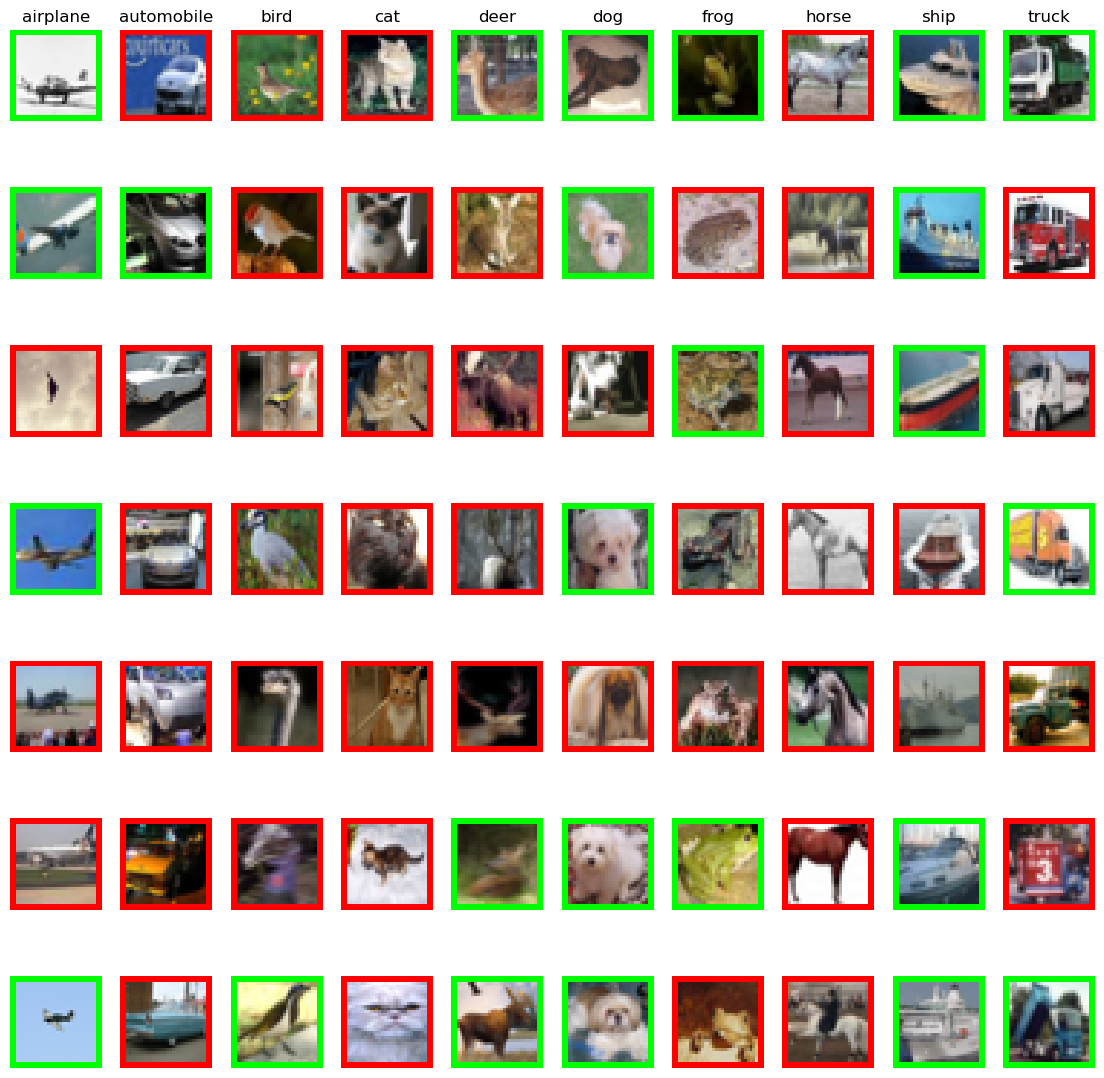

In [24]:
# 写的简单点，训练少一点，方便光速下一波的内容
# 还是一样，照搬红绿正误图过来

classes = cifar10.classes
num_classes = len(classes)
samples_per_class = 7
plt.figure(figsize=(14, 14))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y) #numpy来取
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        y_pre=model(
            torch.from_numpy(X_test[idx]).to(dev).float()
        )#测试集数据已经做过处理了
        _,y_pre=torch.max(y_pre,dim=0)
        
        if y_pre==y:#对的用绿的
            X_original = X_test[idx][:-1] * np.sqrt(variance ) + mean
            x = X_original.reshape(32,32,3) # 获取图片数据
            x[:, :2, :] = [0, 255, 0]
            x[:, -2:, :] = [0, 255, 0] # 左右边缘赋值为红色，[-2:, :] 中的 -2: 表示后两列，: 表示全部行，:表示全部通道，即RGB三通道；[255, 0, 0] 表示红色
            x[:2, :, :] = [0, 255, 0] # 上下边缘赋值为红色， [:, :2, :] 中的 :2 表示前两列，: 表示全部行，:表示全部通道，即RGB三通道；[255, 0, 0] 表示红色
            x[-2:, :, :] = [0, 255, 0]
        else:#错的用红的
            X_original = X_test[idx][:-1] * np.sqrt(variance ) + mean
            x = X_original.reshape(32,32,3) # 获取图片数据
            x[:, :2, :] = [255, 0, 0]
            x[:, -2:, :] = [255, 0, 0] # 左右边缘赋值为红色，[-2:, :] 中的 -2: 表示后两列，: 表示全部行，:表示全部通道，即RGB三通道；[255, 0, 0] 表示红色
            x[:2, :, :] = [255, 0, 0] # 上下边缘赋值为红色， [:, :2, :] 中的 :2 表示前两列，: 表示全部行，:表示全部通道，即RGB三通道；[255, 0, 0] 表示红色
            x[-2:, :, :] = [255, 0, 0]
        plt.imshow(x.astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()
#绿色表示模型判断正确的，红色表示错误的

# 有一说一，还是没太看懂这个方法，我是按照全连接层来整的2333

感觉好像应该是有问题的，但我本身就是向着深度学习走的，唉，不管了，下一课，下一课
SVM有自己的损失计算式子，如果想研究的话，得从这里深入了解，SVM的计算式子，但我算了，看下就行了

In [38]:
# 在整什么奇怪的东西
s="\n\
                           _ooOoo_\n\
                          o8888888o\n\
                          88\" . \"88\n\
                          (| -_- |)\n\
                          O\  =  /O\n\
                       ____/`---'\____\n\
                     .'  \\|     |//  `.\n\
                    /  \\|||  :  |||//  \\\n\
                   /  _||||| -:- |||||-  \\\n\
                   |   | \\\  -  /// |   |\n\
                   | \_|  ''\---/''  |   |\n\
                   \  .-\__  `-`  ___/-. /\n\
                 ___`. .'  /--.--\  `. . __\n\
              ."" '<  `.___\_<|>_/___.'  >'"".\n\
             | | :  `- \`.;`\ _ /`;.`/ - ` : | |\n\
             \  \ `-.   \_ __\ /__ _/   .-` /  /\n\
        ======`-.____`-.___\_____/___.-`____.-'======\n\
                           `=---='\n\
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n\
                 佛祖保佑       永无BUG\n\
"
#                            _ooOoo_
#                           o8888888o
#                           88\" . \"88
#                           (| -_- |)
#                           O\  =  /O
#                        ____/`---'\____
#                      .'  \\|     |//  `.
#                     /  \\|||  :  |||//  \
#                    /  _||||| -:- |||||-  \
#                    |   | \\\  -  /// |   |
#                    | \_|  ''\---/''  |   |
#                    \  .-\__  `-`  ___/-. /
#                  ___`. .'  /--.--\  `. . __
#               ."" '<  `.___\_<|>_/___.'  >'"".
#              | | :  `- \`.;`\ _ /`;.`/ - ` : | |
#              \  \ `-.   \_ __\ /__ _/   .-` /  /
#         ======`-.____`-.___\_____/___.-`____.-'======
#                            `=---='
#         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#                  佛祖保佑       永无BUG

print(s)


                           _ooOoo_
                          o8888888o
                          88" . "88
                          (| -_- |)
                          O\  =  /O
                       ____/`---'\____
                     .'  \|     |//  `.
                    /  \|||  :  |||//  \
                   /  _||||| -:- |||||-  \
                   |   | \\  -  /// |   |
                   | \_|  ''\---/''  |   |
                   \  .-\__  `-`  ___/-. /
                 ___`. .'  /--.--\  `. . __
              . '<  `.___\_<|>_/___.'  >'.
             | | :  `- \`.;`\ _ /`;.`/ - ` : | |
             \  \ `-.   \_ __\ /__ _/   .-` /  /
        ======`-.____`-.___\_____/___.-`____.-'======
                           `=---='
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                 佛祖保佑       永无BUG



In [39]:
# 2333，回头来写损失函数了

# 哦，我完全懂了，我写成了softmax了，SVM的核心也就是那个SVM_loss.懒得再写了，反正我懂了233333，下一课下一课。赶进度呢